In [84]:

import sys
from PIL import Image
from saliency.dataset import SaliencyDataset
from saliency.metrics import SEQUENTIAL_METRICS, make_engine, multi_match
import numpy as np
from scipy.special import erf
from multiprocessing.dummy import Pool as ThreadPool
import time
from saliency.metrics.utils import _create_sub_matrix
import threading

import sys
from PIL import Image
from scipy.special import erf


import matplotlib as mlt
import matplotlib.pyplot as plt
import cycler
from pylab import rcParams




np.warnings.filterwarnings('ignore')
np.set_printoptions(precision=3)


In [7]:


def intersection(mean_1, std_1, mean_2, std_2):
	def C(mean_1, std_1, mean_2, std_2):
			var_1 = std_1 **2
			var_2 = std_2 **2
			c  = (mean_2 * var_1) - 					 (std_2 *
					 	(
					 		(mean_1 * std_2) +
					 		std_1 * np.sqrt(
					 			np.power(mean_1-mean_2,2) +
					 			(2 * (var_1 - var_2) * np.log(std_1/std_2))
					 	)
					 )
					 )
			return c / (var_1 - var_2)
	c = C(mean_1, std_1, mean_2, std_2)
	result = 1 - 			(0.5 * erf((c - mean_1) / (np.sqrt(2)*std_1))) + 			(0.5 * erf((c - mean_2) / (np.sqrt(2)*std_2)))
	return result



def add_noise(seq, v_angle=24, coef=0.5, height=600, width=800):
	noise = np.random.rand(seq.shape[0], seq.shape[1]) * v_angle * coef
	tmp = seq + noise
	tmp[tmp[:,0] >= width,0] = width - 1
	tmp[tmp[:,1] >= height,1] = height - 1
	tmp[tmp[:,0] <=0, 0] = 1
	tmp[tmp[:,1] <= 0, 1] = 1
	return tmp

def add_offset(seq, v_angle=24, coef=1, height=600, width=800):
	noise = np.random.rand(1,2) * v_angle * coef
	tmp = seq + noise
	tmp[tmp[:,0] >= width,0] = width - 1
	tmp[tmp[:,1] >= height,1] = height - 1
	tmp[tmp[:,0] <=0, 0] = 1
	tmp[tmp[:,1] <= 0, 1] = 1
	return tmp


def ord_offset(seq, roll=1):
	return np.roll(seq, roll, axis=0)


def reverse_ordinal_offset(seq, roll=0):
	return np.roll(seq[::-1], roll, axis=0)


def scale(seq, s=0.5, height=600, width=800): #0.5 to 2
	max_x = seq[:,0].max()
	min_x = seq[:,0].min()
	max_y = seq[:,1].max()
	min_y = seq[:,1].min()
	mid_x = min_x + ((max_x - min_x ) / 2)
	mid_y = min_y + ((max_y - min_y ) / 2)
	tmp = list()
	for fix in seq:
		x, y = fix[:2]
		x = mid_x + ((x - mid_x) * s)
		y = mid_y + ((y - mid_y) * s)
		tmp.append([x, y])
	tmp = np.array(tmp)
	tmp[tmp[:,0] >= width,0] = width - 1
	tmp[tmp[:,1] >= height,1] = height - 1
	tmp[tmp[:,0] <=0, 0] = 1
	tmp[tmp[:,1] <= 0, 1] = 1
	return tmp

metrics = SEQUENTIAL_METRICS


metrics_names = ['EUC', 'MAN', 'EYE', 'LEV', 'SMT', 'HAU', 'FRE', 'DTW']
metrics_names += ['TDE', 'REC', 'DET', 'LAM', 'CORM', 'MM_S', 'MM_A']
metrics_names += ['MM_L', 'MM_P', 'MM_D']



In [ ]:




dataset = SaliencyDataset()
dataset.load('OSIE')
target = dataset.get('heatmap_path')
dataset_size = len(dataset)
seqs = dataset.get('sequence', modify='remove')
# lseqs = dataset.get('sequence_mouse_lab')
eng = make_engine()
# eng = None

spatial_offset = np.zeros((len(dataset), 11, 15, len(metrics) + 4))
ordinal_offset = np.zeros((len(dataset), 20, 15, len(metrics) + 4))
rev_ordinal_offset = np.zeros((len(dataset), 20, 15, len(metrics) + 4))
scale_result = np.zeros((len(dataset), 17, 15, len(metrics) + 4))

SubMatrix = _create_sub_matrix()

path = '/home/ramin/codes/SaliencyBundle/results/OSIE/'


In [ ]:

for img_idx, img in enumerate(seqs):
	print(img_idx)
	img_size = dataset.data[img_idx]['img_size']
	for user_idx, user in enumerate(img):
		for noise_idx, noise in enumerate(range(11)):
			user_noisy = add_offset(user[:,:2], coef=noise)
			for metric_idx, metric in enumerate(metrics):
				try:
					tmp = metric(P=user[:,:2], Q=user_noisy[:,:2],
							height=img_size[0], width=img_size[1], matlab_engine=eng, threshold=2*24)
					if isinstance(np.array(tmp).flatten(), np.float64):
						print(img_idx, i, user_idx, metric_idx)
					if metric != multi_match:
						spatial_offset[img_idx, noise_idx, user_idx, metric_idx] = tmp
					else:
						spatial_offset[img_idx, noise_idx, user_idx, metric_idx:] = np.array(tmp).flatten()
				except Exception as x:
					pass




with open('results/spatial_offset.npz', 'wb') as f:
	np.save(f, spatial_offset)



In [ ]:
for img_idx, img in enumerate(seqs):
	print(img_idx)
	img_size = dataset.data[img_idx]['img_size']
	for user_idx, user in enumerate(img):
		len_user = user.shape[0] if user.shape[0] < 20 else 20
		for noise_idx, noise in enumerate(range(len_user)):
			user_noisy = ord_offset(user[:,:2], roll=noise)
			for metric_idx, metric in enumerate(metrics):
				try:
					tmp = metric(P=user[:,:2], Q=user_noisy[:,:2],
							height=img_size[0], width=img_size[1], matlab_engine=eng, threshold=2*24)
					if isinstance(np.array(tmp).flatten(), np.float64):
						print(img_idx, i, user_idx, metric_idx)
					if metric != multi_match:
						ordinal_offset[img_idx, noise_idx, user_idx, metric_idx] = tmp
					else:
						ordinal_offset[img_idx, noise_idx, user_idx, metric_idx:] = np.array(tmp).flatten()
				except Exception as x:
					pass
                
                
with open('results/ordinal_offset.npz', 'wb') as f:
	np.save(f, ordinal_offset)




In [ ]:
for img_idx, img in enumerate(seqs):
	print(img_idx)
	img_size = dataset.data[img_idx]['img_size']
	for user_idx, user in enumerate(img):
		len_user = user.shape[0] if user.shape[0] < 20 else 20
		for noise_idx, noise in enumerate(range(len_user)):
			user_noisy = reverse_ordinal_offset(user[:,:2], roll=noise)
			for metric_idx, metric in enumerate(metrics):
				try:
					tmp = metric(P=user[:,:2], Q=user_noisy[:,:2],
							height=img_size[0], width=img_size[1], matlab_engine=eng, threshold=2*24)
					if isinstance(np.array(tmp).flatten(), np.float64):
						print(img_idx, i, user_idx, metric_idx)
					if metric != multi_match:
						rev_ordinal_offset[img_idx, noise_idx, user_idx, metric_idx] = tmp
					else:
						rev_ordinal_offset[img_idx, noise_idx, user_idx, metric_idx:] = np.array(tmp).flatten()
				except Exception as x:
					pass



with open('results/rev_ordinal_offset.npz', 'wb') as f:
	np.save(f, rev_ordinal_offset)


In [ ]:
for img_idx, img in enumerate(seqs):
	print(img_idx)
	img_size = dataset.data[img_idx]['img_size']
	for user_idx, user in enumerate(img):
		len_user = user.shape[0] if user.shape[0] < 20 else 20
		for noise_idx, noise in enumerate(np.arange(0.5,2.1,0.1)):
			user_noisy = scale(user[:,:2], s=noise)
			for metric_idx, metric in enumerate(metrics):
				try:
					tmp = metric(P=user[:,:2], Q=user_noisy[:,:2],
							height=img_size[0], width=img_size[1], matlab_engine=eng, threshold=2*24)
					if isinstance(np.array(tmp).flatten(), np.float64):
						print(img_idx, i, user_idx, metric_idx)
					if metric != multi_match:
						scale_result[img_idx, noise_idx, user_idx, metric_idx] = tmp
					else:
						scale_result[img_idx, noise_idx, user_idx, metric_idx:] = np.array(tmp).flatten()
				except Exception as x:
					pass
                

with open('results/scale_result.npz', 'wb') as f:
	np.save(f, scale_result)


In [164]:
spatial_noise = np.load('results/spatial_noise.npz')
spatial_offset = np.load('results/spatial_offset.npz')
ordinal_offset = np.load('results/ordinal_offset.npz')
rev_ordinal_offset = np.load('results/rev_ordinal_offset.npz')
scale_result = np.load('results/scale_result.npz')

In [172]:


sp_noise = np.nanmean(spatial_noise[:,:,:,:-1], axis=(0,2)).T
# sp_offset = np.log2(np.nanmean(spatial_offset, axis=(0,2))[1:]).T
sp_offset[:,0] = 0


mask = (sp_noise.mean(axis=1) < 1)


fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(13,5))
# plt.style.use('seaborn')

ax_1.spines['top'].set_visible(False)
ax_1.spines['right'].set_visible(False)
ax_1.set_ylabel('Avg distance', fontsize=15)
ax_1.set_xlabel('Spatial offset (DVA)', fontsize=15)
ax_1.set_xticks(range(20))
ax_1.set_xticklabels(np.arange(.5, 10.5, 0.5))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticklabels([str(round(item,1)) for item in np.arange(0, 1.1, 0.1)])
ax_2.set_xticks(range(20))
ax_2.set_xticklabels([str(item) for item [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
                     ])
ax_2.set_ylabel('Avg distance (log)', fontsize=15)
ax_2.set_xlabel('Spatial offset (DVA)', fontsize=15)

font = {'family' : 'normal',
		# 'weight' : 'bold', 
		'size'   : 16
}


cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, 18))


for row_idx, row in enumerate(sp_noise):
    if mask[row_idx]:
        ax_1.plot(range(20), sp_noise[row_idx,], label=metrics_names[row_idx], color=colors[row_idx])
    else:
        ax_2.plot(range(20), np.log2(sp_noise[row_idx,]), label=metrics_names[row_idx], color=colors[row_idx])

ax_1.legend(loc=4)
ax_1.grid(True)
ax_2.legend(loc=4, bbox_to_anchor=(1.1, 0.2))
ax_2.grid(True)

# rcParams['figure.figsize'] = 5,15

# plt.savefig('figs/spatial_offset.png', format='png', dpi=600)#, figsize=(8, 12))
#


SyntaxError: invalid syntax (<ipython-input-172-93cdc67ce539>, line 24)

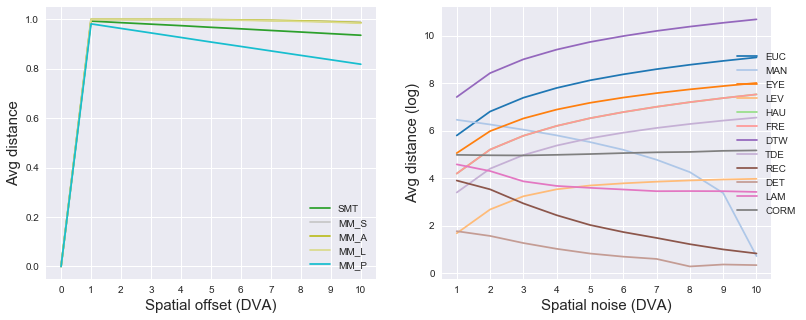

In [163]:


sp_offset = np.nanmean(spatial_offset[:,:,:,:-1], axis=(0,2)).T
# sp_offset = np.log2(np.nanmean(spatial_offset, axis=(0,2))[1:]).T
sp_offset[:,0] = 0


mask = (sp_offset.mean(axis=1) < 1)


fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(13,5))
# plt.style.use('seaborn')

ax_1.spines['top'].set_visible(False)
ax_1.spines['right'].set_visible(False)
ax_1.set_ylabel('Avg distance', fontsize=15)
ax_1.set_xlabel('Spatial offset (DVA)', fontsize=15)
ax_1.set_xticks(range(11))
ax_1.set_xticklabels(range(11))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticklabels([str(round(item,1)) for item in np.arange(0, 1.1, 0.1)])
ax_2.set_xticks(range(10))
ax_2.set_xticklabels(range(1,11))
ax_2.set_ylabel('Avg distance (log)', fontsize=15)
ax_2.set_xlabel('Spatial noise (DVA)', fontsize=15)

font = {'family' : 'normal',
		# 'weight' : 'bold', 
		'size'   : 16
}


cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, 18))


for row_idx, row in enumerate(sp_offset):
    if mask[row_idx]:
        ax_1.plot(range(11), sp_offset[row_idx,], label=metrics_names[row_idx], color=colors[row_idx])
    else:
        ax_2.plot(range(10), np.log2(sp_offset[row_idx,1:]), label=metrics_names[row_idx], color=colors[row_idx])

ax_1.legend(loc=4)
ax_1.grid(True)
ax_2.legend(loc=4, bbox_to_anchor=(1.1, 0.2))
ax_2.grid(True)

# rcParams['figure.figsize'] = 5,15

plt.savefig('figs/spatial_offset.png', format='png', dpi=600)#, figsize=(8, 12))
#


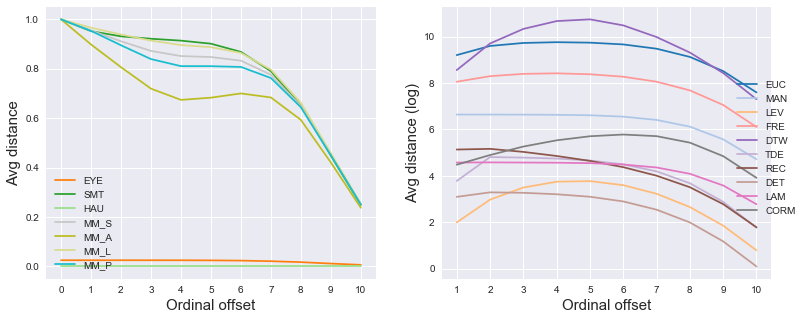

In [138]:

ordinal_offset[np.where(ordinal_offset[:,1:,:,] == 0)] == np.nan

ord_offset = np.nanmean(ordinal_offset[:,:,:,:-1], axis=(0,2))[:11,].T
# sp_offset = np.log2(np.nanmean(spatial_offset, axis=(0,2))[1:]).T
# sp_offset[:,0] = 0


mask = (ord_offset.mean(axis=1) < 1)


fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(13,5))
# plt.style.use('seaborn')

ax_1.spines['top'].set_visible(False)
ax_1.spines['right'].set_visible(False)
ax_1.set_ylabel('Avg distance', fontsize=15)
ax_1.set_xlabel('Ordinal offset', fontsize=15)
ax_1.set_xticks(range(11))
ax_1.set_xticklabels(range(11))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticklabels([str(round(item,1)) for item in np.arange(0, 1.1, 0.1)])
ax_2.set_xticks(range(10))
ax_2.set_xticklabels(range(1,11))
ax_2.set_ylabel('Avg distance (log)', fontsize=15)
ax_2.set_xlabel('Ordinal offset', fontsize=15)

font = {'family' : 'normal',
		# 'weight' : 'bold', 
		'size'   : 16
}


cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, 18))


for row_idx, row in enumerate(ord_offset):
    if mask[row_idx]:
        ax_1.plot(range(11), ord_offset[row_idx,], label=metrics_names[row_idx], color=colors[row_idx])
    else:
        ax_2.plot(range(10), np.log2(ord_offset[row_idx,1:]), label=metrics_names[row_idx], color=colors[row_idx])

ax_1.legend(loc=3)
ax_1.grid(True)
ax_2.legend(loc=4, bbox_to_anchor=(1.1, 0.2))
ax_2.grid(True)

# rcParams['figure.figsize'] = 5,15

plt.savefig('figs/ordinal_offset.png', format='png', dpi=600)#, figsize=(8, 12))
#


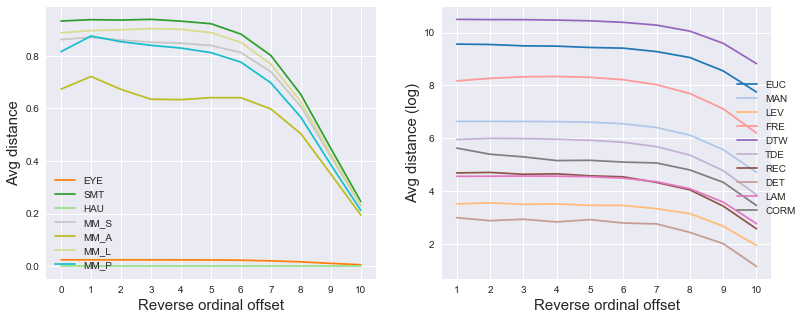

In [139]:

rev_ordinal_offset[np.where(rev_ordinal_offset[:,1:,:,] == 0)] == np.nan

rev_ord_offset = np.nanmean(rev_ordinal_offset[:,:,:,:-1], axis=(0,2))[:11,].T
# sp_offset = np.log2(np.nanmean(spatial_offset, axis=(0,2))[1:]).T
# sp_offset[:,0] = 0


mask = (rev_ord_offset.mean(axis=1) < 1)


fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(13,5))
# plt.style.use('seaborn')

ax_1.spines['top'].set_visible(False)
ax_1.spines['right'].set_visible(False)
ax_1.set_ylabel('Avg distance', fontsize=15)
ax_1.set_xlabel('Reverse ordinal offset', fontsize=15)
ax_1.set_xticks(range(11))
ax_1.set_xticklabels(range(11))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticklabels([str(round(item,1)) for item in np.arange(0, 1.1, 0.1)])
ax_2.set_xticks(range(10))
ax_2.set_xticklabels(range(1,11))
ax_2.set_ylabel('Avg distance (log)', fontsize=15)
ax_2.set_xlabel('Reverse ordinal offset', fontsize=15)

font = {'family' : 'normal',
		# 'weight' : 'bold', 
		'size'   : 16
}


cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, 18))


for row_idx, row in enumerate(rev_ord_offset):
    if mask[row_idx]:
        ax_1.plot(range(11), rev_ord_offset[row_idx,], label=metrics_names[row_idx], color=colors[row_idx])
    else:
        ax_2.plot(range(10), np.log2(rev_ord_offset[row_idx,1:]), label=metrics_names[row_idx], color=colors[row_idx])

ax_1.legend(loc=3)
ax_1.grid(True)
ax_2.legend(loc=4, bbox_to_anchor=(1.1, 0.2))
ax_2.grid(True)

# rcParams['figure.figsize'] = 5,15

plt.savefig('figs/rev_ordinal_offset.png', format='png', dpi=600)#, figsize=(8, 12))
#

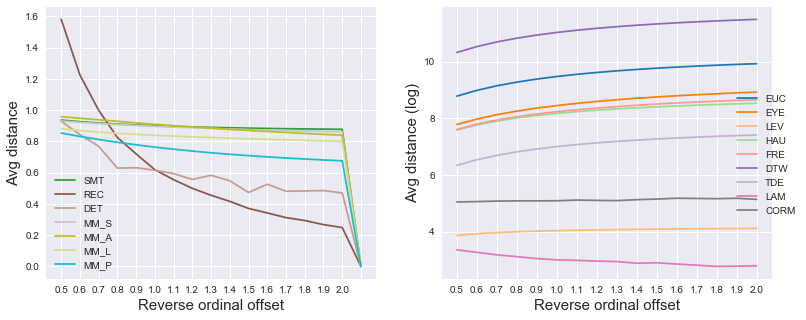

In [158]:

scale_result[np.where(scale_result[:,1:,:,] == 0)] == np.nan

sc = np.nanmean(scale_result[:,:,:,:-1], axis=(0,2)).T
# sp_offset = np.log2(np.nanmean(spatial_offset, axis=(0,2))[1:]).T
# sp_offset[:,0] = 0


mask = (sc.mean(axis=1) < 1)


fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(13,5))
# plt.style.use('seaborn')

ax_1.spines['top'].set_visible(False)
ax_1.spines['right'].set_visible(False)
ax_1.set_ylabel('Avg distance', fontsize=15)
ax_1.set_xlabel('Reverse ordinal offset', fontsize=15)
ax_1.set_xticks(range(17))
ax_1.set_xticklabels(["{:.1f}".format(item) for item in np.arange(0.5,2.1,0.1)])
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_yticklabels([str(round(item,1)) for item in np.arange(0, 1.1, 0.1)])

ax_2.set_xticks(range(17))
ax_2.set_xticklabels(["{:.1f}".format(item) for item in np.arange(0.5,2.1,0.1)])
ax_2.set_ylabel('Avg distance (log)', fontsize=15)
ax_2.set_xlabel('Reverse ordinal offset', fontsize=15)

font = {'family' : 'normal',
		# 'weight' : 'bold', 
		'size'   : 16
}


cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, 18))


for row_idx, row in enumerate(sc):
    if row_idx == 1:
        continue
    if mask[row_idx]:
        ax_1.plot(range(17), sc[row_idx,], label=metrics_names[row_idx], color=colors[row_idx])
    else:
        ax_2.plot(range(17), np.log2(sc[row_idx,]), label=metrics_names[row_idx], color=colors[row_idx])

ax_1.legend(loc=3)
ax_1.grid(True)
ax_2.legend(loc=4, bbox_to_anchor=(1.1, 0.2))
ax_2.grid(True)

# rcParams['figure.figsize'] = 5,15

# plt.savefig('figs/scale.png', format='png', dpi=600)#, figsize=(8, 12))
#

In [155]:
["{:.1f}".format(item) for item in np.arange(0.5,2.1,0.1)]

['0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1.0',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9',
 '2.0']

In [161]:
sc[6]

array([194.938, 221.815, 245.281, 265.904, 284.052, 300.217, 314.806,
       328.029, 340.244, 351.507, 361.859, 371.392, 380.249, 388.439,
       396.037, 403.069,   0.   ])